In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import os
import matplotlib
import warnings
warnings.filterwarnings('ignore')

In [216]:
sp500_download_url = 'https://raw.githubusercontent.com/datasets/s-and-p-500-companies/main/data/constituents.csv'
df_sp500 = pd.read_csv(sp500_download_url)
df_sp500_weights = pd.read_csv('./data/SP500_weightage.csv')
stock_weightage = df_sp500_weights.set_index('Symbol')['Portfolio%'].to_dict()
df_sp500['Symbol'] = df_sp500['Symbol'].str.replace('.','-')
sector_dict = df_sp500.set_index('Symbol')['GICS Sector'].to_dict()
ticker_list = list(sector_dict.keys())
ticker_list.append('^GSPC')
df_sp500.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [217]:
# Function to get the first and last price for each ticker and calculate the percentage change in the price
def fmax(df):
    #Getting the first day and last day SMA_15 stock price
    df['first_price'] =  df.sort_values(['Date']).head(1)['SMA_15'].squeeze()
    df['last_price'] = df.sort_values(['Date']).tail(1)['SMA_15'].squeeze()
    # Calculating the percentage change between the latest price and price 2y before
    df['pct_change'] =  (df['last_price'] - df['first_price'])*100/(df['first_price'])
    df = df.reset_index()
    df = df.drop_duplicates(subset = ['Ticker'])
    df = df[['Ticker','first_price', 'last_price', 'pct_change']]
    return df

In [239]:
def get_stock_performance(tickers,period='2y', save = False):
    """
    tickers: list of ticker symbols for which 2 year data needs to be queried
    period: time period
    Returns:
    dataframe: columns - stocks, 
    """
    op_path = './data/'
    today = str(datetime.datetime.today().date())
    fname = f'{op_path}SP500_{period}_stock_data_{today}.csv'
    if os.path.exists(fname):
        data_prep = pd.read_csv(fname)
        data_prep['Date'] = pd.to_datetime(data_prep['Date'])
    else:
        stock_2y_data = yf.Tickers(' '.join(tickers)).history(period)
        null_cols_sum = stock_2y_data.isna().sum()
        null_cols = null_cols_sum[null_cols_sum == len(stock_2y_data)].index
        
        ### Sometimes Yahoo Finance API does not return data for all stocks. 
        non_null_cols = [col for col in stock_2y_data.columns if col not in null_cols]
        stock_2y_data = stock_2y_data[non_null_cols]
        null_tickers = list(set([col[1] for col in null_cols]))

        ## Redownload stock data
        if len(null_tickers) > 0:
            if len(null_tickers) ==1:
                redown_stock_2y_data = yf.Ticker(' '.join(null_tickers)).history(period)
            else:
                redown_stock_2y_data = yf.Tickers(' '.join(null_tickers)).history(period)
            stock_2y_data = pd.concat([stock_2y_data,redown_stock_2y_data ], axis=1)
            
        ### Only choose Open and Close prices
        sel_cols = [col for col in stock_2y_data.columns if 'High' in col or 'Low' in col]
        data_prep = stock_2y_data[sel_cols].unstack().reset_index()
        data_prep = data_prep.rename(columns = {'level_0':'type','level_1':'ticker', 0:'value', 'Date':'date'})
        data_prep = data_prep.pivot(index = ['ticker', 'date'], columns = ['type'], values = ['value']).reset_index()
        data_prep.columns = data_prep.columns.droplevel()
        data_prep.columns = ['Ticker', 'Date', 'High', 'Low']
        
        # Average Price between High and Low
        data_prep['daily_avg_price'] = (data_prep['High']  + data_prep['Low'])/2
        data_prep = data_prep.dropna()
        data_prep = data_prep.sort_values(['Ticker', 'Date'])
        
        # Calculate Simple Moving Average (SMA) for 15 days
        data_prep['SMA_15'] = data_prep.groupby('Ticker')['daily_avg_price'].rolling(15, min_periods=1, center = True).mean().values
    
    stock_performance = data_prep.groupby(['Ticker']).apply(fmax).reset_index(drop=True)
    stock_performance['Sector'] = stock_performance['Ticker'].map(sector_dict)
    stock_performance['Stock_Weight'] = stock_performance['Ticker'].map(stock_weightage)
    stock_performance['performance_label'] = pd.qcut(stock_performance['pct_change'], 
                                                     5, labels=["decline-high", 'decline-low',  "flat", "up-low", 'up-high'])
    
    # Calculate 
    data_prep['pct_change_day1'] = data_prep.groupby('Ticker').SMA_15.apply(lambda x: (x - x.iloc[0])*100/x.iloc[0]).values
    data_prep['Sector'] = data_prep['Ticker'].map(sector_dict)
    data_prep['Stock_Weight'] = data_prep['Ticker'].map(stock_weightage)
        
    if save:
        os.makedirs(op_path, exist_ok=True)
        data_prep.to_csv(fname, index=False)
    return data_prep, stock_performance

In [221]:
stock_data,stock_performance = get_stock_performance(tickers=ticker_list, save= True)
stock_performance.head()

[*********************100%%**********************]  504 of 504 completed


,Ticker,first_price,last_price,pct_change,Sector,Stock_Weight,performance_label
0,A,154.761624,110.046875,-28.892659,Health Care,0.09,decline-low
1,AAL,19.428750,11.694375,-39.808916,Industrials,0.02,decline-high
2,AAPL,147.902019,176.685311,19.461055,Information Technology,7.16,up-high
3,ABBV,103.671473,147.500625,42.276964,Health Care,0.71,up-high
4,ABNB,170.981750,123.194751,-27.948596,Consumer Discretionary,0.15,decline-low


In [222]:
stock_data.head()

,Ticker,Date,High,Low,daily_avg_price,SMA_15,pct_change_day1,Sector,Stock_Weight
0,A,2021-10-25,156.406276,154.659873,155.533075,154.761624,0.000000,Health Care,0.09
1,A,2021-10-26,157.787601,154.945998,156.366800,154.848434,0.056093,Health Care,0.09
2,A,2021-10-27,156.386530,152.765469,154.576000,154.619420,-0.091885,Health Care,0.09
3,A,2021-10-28,155.685990,152.134002,153.909996,154.811460,0.032202,Health Care,0.09
4,A,2021-10-29,155.468934,152.380666,153.924800,155.137995,0.243194,Health Care,0.09


In [223]:
stock_performance.groupby('Sector').agg({'Sector':['size'],'Stock_Weight':['sum'],'pct_change':['mean','median'] }).round()

Sector Stock_Weight pct_change       
                         size          sum       mean median
Sector                                                      
Communication Services     22          9.0      -22.0  -16.0
Consumer Discretionary     53         11.0      -14.0  -13.0
Consumer Staples           38          6.0       -4.0    3.0
Energy                     23          5.0       67.0   63.0
Financials                 72         11.0      -11.0  -16.0
Health Care                64         13.0       -7.0  -16.0
Industrials                77          8.0        1.0   -0.0
Information Technology     64         28.0       -1.0   -9.0
Materials                  29          2.0       -7.0  -14.0
Real Estate                31          2.0      -21.0  -21.0
Utilities                  30          2.0        4.0   -2.0

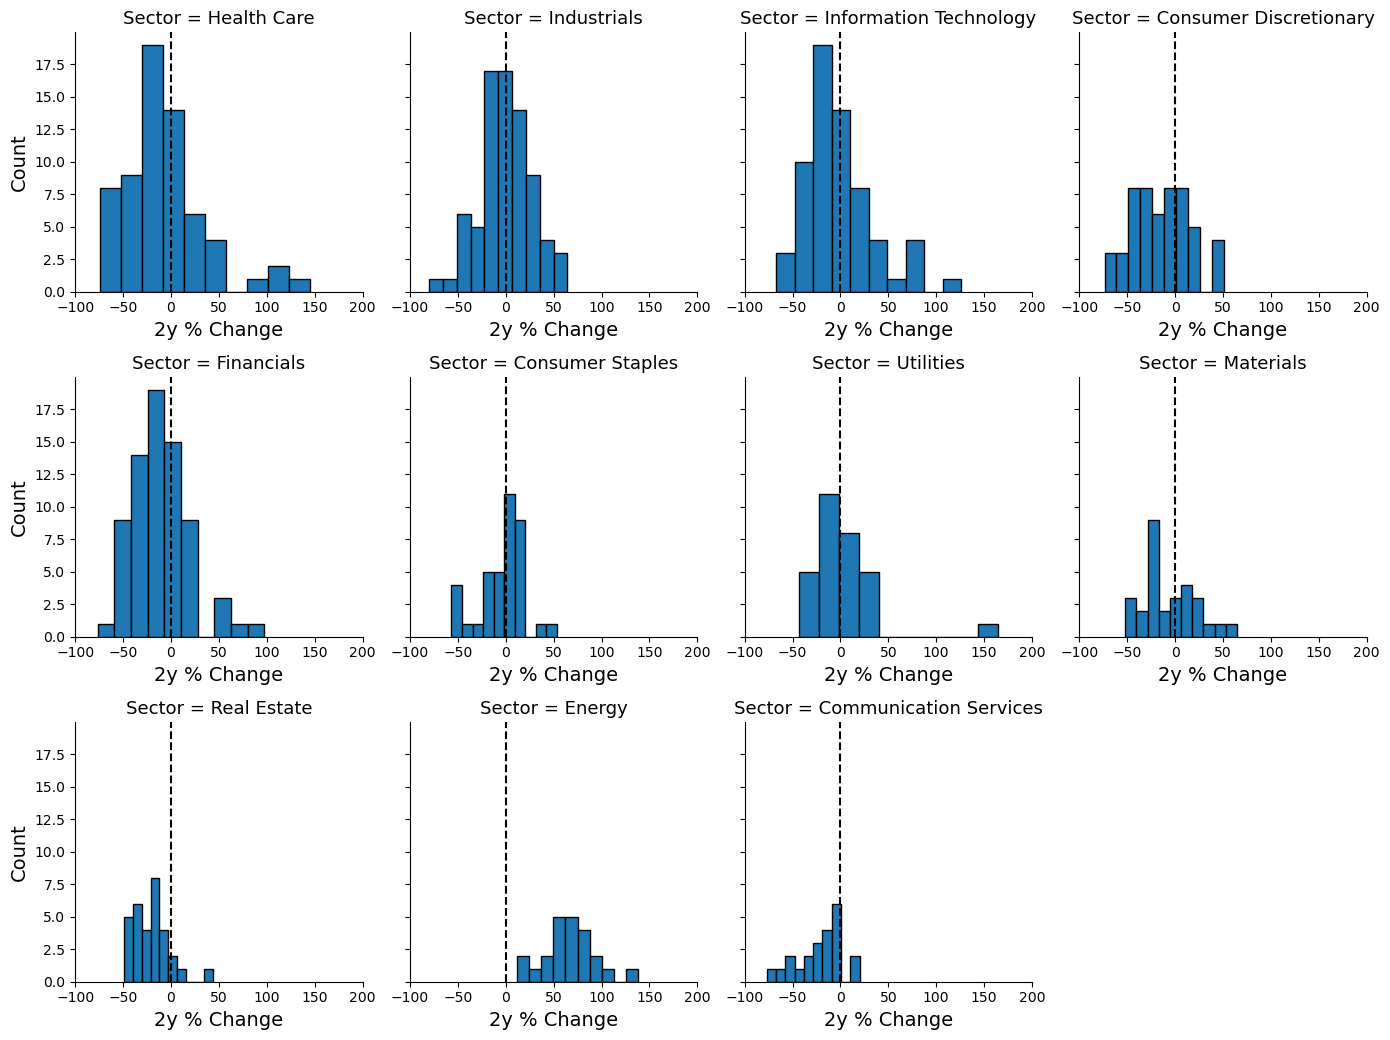

In [224]:
def individual_plot(**kwargs):
     ax = plt.gca()  # get the current ax
     data = kwargs['data']['pct_change'].values
     ax.hist(data,edgecolor='k')
     ax.axvline(0, color='k', ls='--')
     ax.set_xlim(-100,200)
     ax.set_xlabel('2y % Change', fontsize =14)
     ax.set_ylabel('Count', fontsize =14)
     # calculate and show part < 0
g = sns.FacetGrid(stock_performance, col="Sector",  height=3.5, col_wrap=4,sharex=False)
g.set_titles(size=13)
g.map_dataframe(individual_plot)

In [225]:
stock_performance['performance_label_rank'] = pd.qcut(stock_performance['pct_change'], 
                                                     5, labels=[1,2,3,4,5])
stock_performance['performance_label_rank'] = stock_performance['performance_label_rank'].astype(int)

In [226]:
stock_performance.groupby('Sector')['performance_label_rank'].mean()

Sector
Communication Services    2.318182
Consumer Discretionary    2.660377
Consumer Staples          3.210526
Energy                    4.956522
Financials                2.708333
Health Care               2.750000
Industrials               3.363636
Information Technology    3.125000
Materials                 2.931034
Real Estate               2.129032
Utilities                 3.333333
Name: performance_label_rank, dtype: float64

Text(0.5, 0, 'Date')

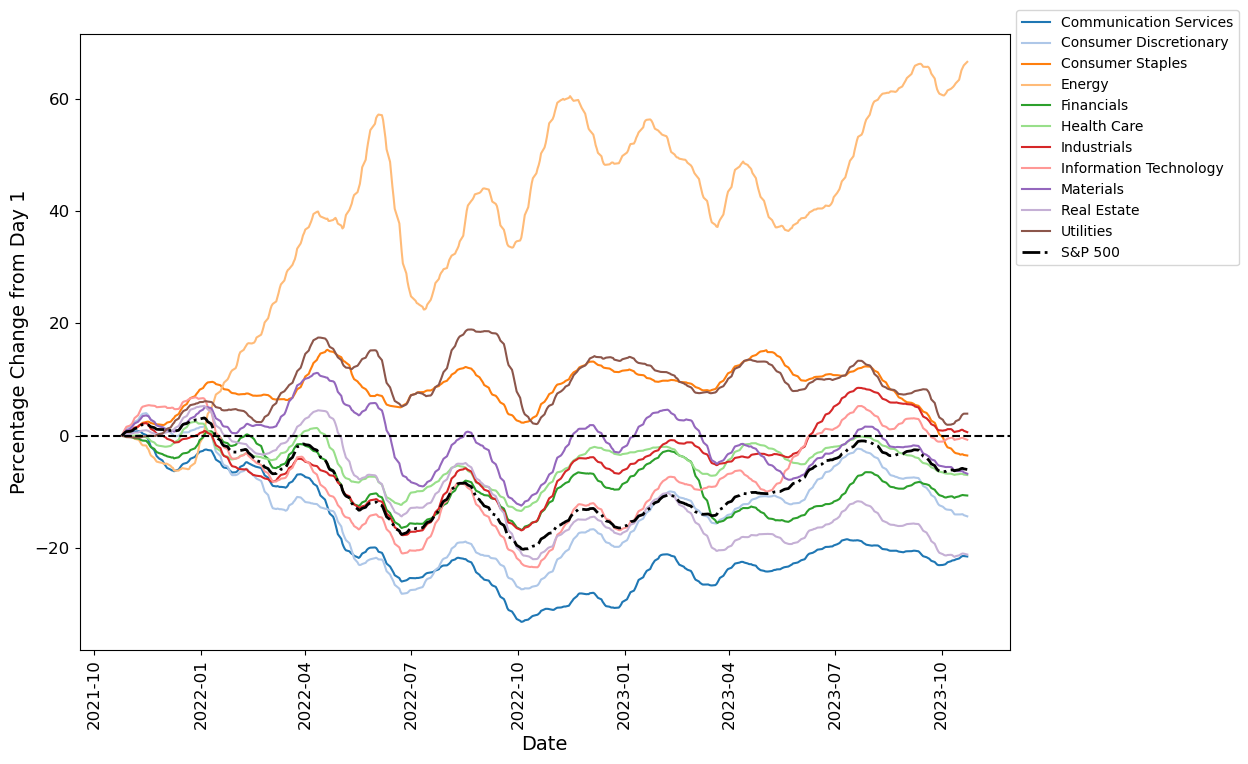

In [227]:
plt.figure(figsize = (12,8))
change_per_day = stock_data.groupby([pd.Grouper(key = 'Date', freq='D'), 'Sector'])['pct_change_day1'].mean().reset_index()
sns.lineplot(data = change_per_day, x = 'Date', y = 'pct_change_day1', hue='Sector', palette='tab20')
sp500  = stock_data[stock_data.Ticker == '^GSPC']
plt.plot(sp500['Date'], sp500['pct_change_day1'], color = 'k', linewidth= 2, linestyle = '-.', label ='S&P 500')
plt.plot()
plt.xticks(rotation=90,fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 14)
plt.axhline(0, color = 'k', linestyle = '--')
plt.legend(bbox_to_anchor=(1, 1.05))
plt.ylabel('Percentage Change from Day 1', fontsize = 14)
plt.xlabel('Date', fontsize = 14)

In [228]:
stock_performance.groupby('performance_label').agg({'pct_change':['min','max']}).round()

pct_change       
                         min    max
performance_label                  
decline-high           -80.0  -31.0
decline-low            -31.0  -15.0
flat                   -14.0    1.0
up-low                   1.0   18.0
up-high                 18.0  165.0

In [229]:
stock_performance.groupby(['Sector','performance_label', ]).size()*100/stock_performance.groupby(['Sector']).size()

Sector                  performance_label
Communication Services  decline-high         31.818182
                        decline-low          18.181818
                        flat                 40.909091
                        up-low                4.545455
                        up-high               4.545455
Consumer Discretionary  decline-high         33.962264
                        decline-low          15.094340
                        flat                 16.981132
                        up-low               18.867925
                        up-high              15.094340
Consumer Staples        decline-high         13.157895
                        decline-low          15.789474
                        flat                 18.421053
                        up-low               42.105263
                        up-high              10.526316
Energy                  decline-high          0.000000
                        decline-low           0.000000
                       

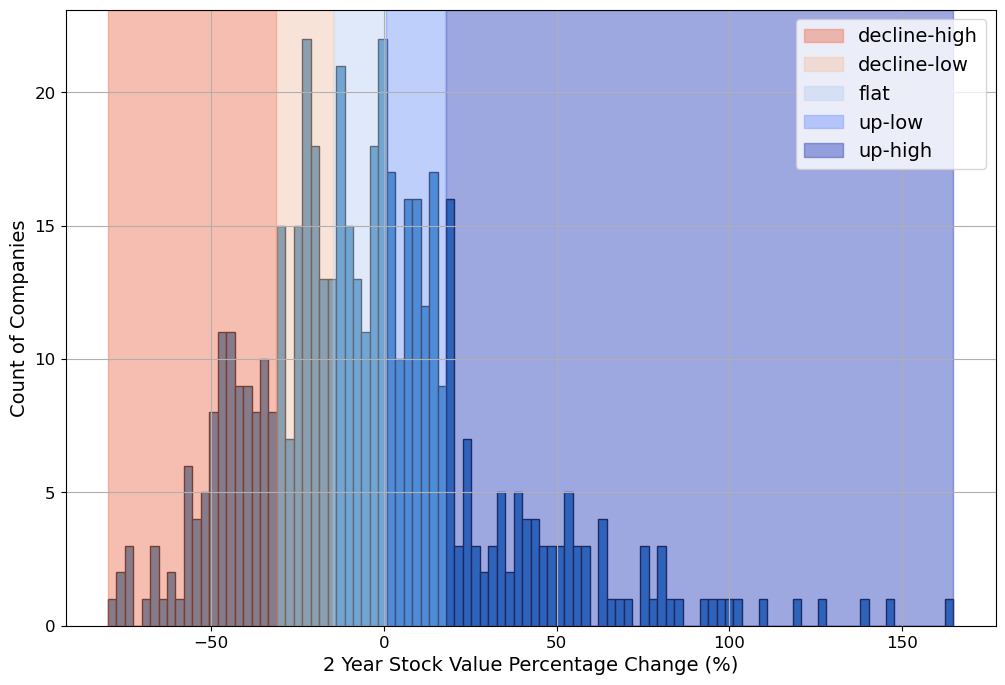

In [230]:
label_pct_change = stock_performance.groupby('performance_label').agg({'pct_change':['min','max']})
plt.figure(figsize = (12,8))
stock_performance['pct_change'].hist(bins=100, edgecolor = 'k')
cmap = matplotlib.colormaps['coolwarm_r']

i=1
for index, row in label_pct_change.iterrows():
    plt.axvspan(row['pct_change']['min'],row['pct_change']['max'], color=cmap(i*(1/len(label_pct_change)) - 0.01), alpha=0.5, lw=1,label = index)
    i+=1
plt.ylabel('Count of Companies', fontsize = 14)
plt.xlabel('2 Year Stock Value Percentage Change (%)', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(loc='upper right', fontsize = 14)

In [231]:
stock_performance['pct_change'].describe().round(2)

count    504.00
mean      -3.57
std       35.88
min      -79.91
25%      -25.30
50%       -7.25
75%       13.17
max      164.77
Name: pct_change, dtype: float64

In [232]:
stock_performance.groupby('Sector').agg({'pct_change':['mean','median']}).round()

pct_change       
                             mean median
Sector                                  
Communication Services      -22.0  -16.0
Consumer Discretionary      -14.0  -13.0
Consumer Staples             -4.0    3.0
Energy                       67.0   63.0
Financials                  -11.0  -16.0
Health Care                  -7.0  -16.0
Industrials                   1.0   -0.0
Information Technology       -1.0   -9.0
Materials                    -7.0  -14.0
Real Estate                 -21.0  -21.0
Utilities                     4.0   -2.0

In [234]:
top_3_stocks = stock_performance.sort_values('pct_change', ascending=False).head(3)['Ticker'].to_list()
bottom_3_stocks = stock_performance.sort_values('pct_change', ascending=False).tail(3)['Ticker'].to_list()
stock_performance[stock_performance.Ticker.isin(top_3_stocks + bottom_3_stocks)].sort_values('pct_change', ascending=False)

,Ticker,first_price,last_price,pct_change,Sector,Stock_Weight,performance_label,performance_label_rank
89,CEG,43.471549,115.100893,164.772931,Utilities,0.10,up-high,5
280,LLY,245.613085,602.861874,145.451855,Health Care,1.34,up-high,5
314,MPC,63.249821,150.872501,138.534274,Energy,0.16,up-high,5
387,PYPL,237.042563,55.744188,-76.483469,Financials,0.17,decline-high,1
324,MTCH,157.234689,36.193750,-76.981066,Communication Services,0.03,decline-high,1
206,GNRC,484.671873,97.372025,-79.909702,Industrials,0.02,decline-high,1


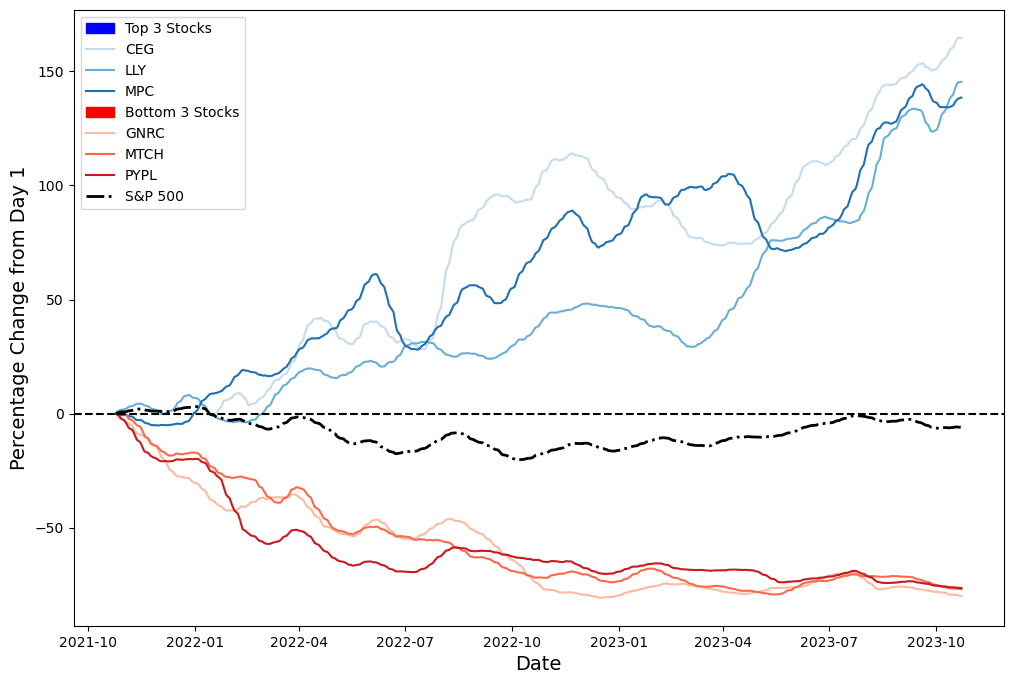

In [235]:
from matplotlib.patches import Patch
plt.figure(figsize = (12,8))
sp500  = stock_data[stock_data.Ticker == '^GSPC']
sp_top3 = stock_data[stock_data.Ticker.isin(top_3_stocks)]
sns.lineplot(data = sp_top3, x = 'Date', y = 'pct_change_day1', hue='Ticker', palette='Blues')
sp_bottom3 = stock_data[stock_data.Ticker.isin(bottom_3_stocks)]
sns.lineplot(data = sp_bottom3, x = 'Date', y = 'pct_change_day1', hue='Ticker', palette='Reds')
plt.plot(sp500['Date'], sp500['pct_change_day1'], color = 'k', linewidth= 2, linestyle = '-.', label ='S&P 500')
plt.axhline(0, color = 'k', linestyle = '--')
plt.legend(bbox_to_anchor=(1, 1.05))
plt.ylabel('Percentage Change from Day 1', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
top3_patch = Patch(facecolor='Blue', edgecolor='blue', label = 'Top 3 Stocks')
bottom3_patch = Patch(facecolor='Red', edgecolor='red', label = 'Bottom 3 Stocks')

handles = [top3_patch, handles[0],handles[1],handles[2],bottom3_patch, handles[3],handles[4],handles[5],handles[6]]
lgd = ax.legend(handles=handles, loc='upper left')


In [236]:
stock_data['daily_change_pct'] = (stock_data.groupby('Ticker')['SMA_15'].diff(1).fillna(0)*100/stock_data['SMA_15'])

In [237]:
daily_change_corr = stock_data.pivot(index = ['Date'], columns = ['Ticker'], values = ['daily_change_pct']).corr()
# daily_change_corr[daily_change_corr>0.5]
upper = daily_change_corr.where(np.triu(np.ones(daily_change_corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] < 0.5)]
daily_change_corr.drop(to_drop, axis=1, inplace=True)
daily_change_corr

daily_change_pct
Ticker                                 A
                 Ticker                 
daily_change_pct A              1.000000
                 AAL            0.337302
                 AAPL           0.372049
                 ABBV           0.245765
                 ABNB           0.315830
...                                  ...
                 ZBH            0.372527
                 ZBRA           0.495811
                 ZION           0.318841
                 ZTS            0.545392
                 ^GSPC          0.677850

[504 rows x 1 columns]

In [238]:
corr_matrix = stock_data_pivot.corr()

diag = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack()
diag.index.names = [None, 'Ticker', 'Corr_Ticker']
diag = diag.reset_index().drop(columns=['level_0']).rename(columns = {'daily_change_pct':'Correlation_Coefficient'})
high_corr_stocks = diag[(diag.Correlation_Coefficient > 0.8)& (diag.Corr_Ticker != '^GSPC')]
high_corr_stocks

,Ticker,Corr_Ticker,Correlation_Coefficient
324,A,MTD,0.814603
524,AAL,ALK,0.858868
585,AAL,CCL,0.800035
630,AAL,DAL,0.919160
828,AAL,NCLH,0.814079
...,...,...,...
125049,TROW,TT,0.819596
125908,URI,WAB,0.807204
125973,USB,ZION,0.859420
126299,VTR,WELL,0.843963
